<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            1. Introduction
            </span>   
        </font>    
</h2>

<h3 >   
      <font color = purple >
            <span style='font-family:Georgia'>
            Introduction:
            </span>   
        </font>    
</h3>
<p>
    <span style='font-family:Georgia'>
 Pneumonia remains a significant global health challenge, with timely and accurate diagnosis being critical for effective patient outcomes. While chest radiography is the primary imaging modality for detection, its interpretation can be time-consuming and requires specialized radiological expertise, which is not always readily available. This project addresses this clinical need by developing a robust deep learning framework to serve as a diagnostic aid. Leveraging the "Chest X-Ray Images (Pneumonia)" dataset, this notebook details an end-to-end workflow, including strategic data re-splitting, advanced augmentation using Albumentations to handle class imbalance, and the iterative development of Convolutional Neural Networks (CNNs). The final solution employs a state-of-the-art Transfer Learning approach with a ResNet50 model, which is fine-tuned to achieve high accuracy in classifying X-rays as either 'Normal' or 'Pneumonia'.

</p>   
<hr>
<h3>
    <font color = purple >
        <span style='font-family:Georgia'>
            Business Understanding:
            </span>   
        </font>    
</h3>
<p>
    <span style='font-family:Georgia'>
        <b>The Clinical Problem:</b><br>
In a clinical setting, the workflow for diagnosing pneumonia involves a radiologist manually inspecting chest X-rays. This process faces several challenges:
        <br>

<li><b>High Workload:</b> Radiologists often face a large volume of images, leading to fatigue and potential diagnostic errors.</li>
<li><b>Expertise Scarcity:</b> Access to expert radiologists can be limited in remote or under-resourced healthcare facilities, causing delays in diagnosis.

</li>
<li><b>Subjectivity:</b> Interpretation can have a degree of subjectivity, leading to inter-observer variability.</li>


<br>
These factors can delay treatment, increase healthcare costs, and negatively impact patient care. The core business need is for an automated, reliable tool that can assist clinicians by providing a rapid and accurate initial screening of chest X-rays.

    </span>
</p>

<hr>
<h3>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Business Objective:
            </span>   
        </font>    
</h3>
<p>
    <span style='font-family:Georgia'>
        The primary objective of this project is to build and evaluate a high-performance deep learning model capable of accurately classifying pediatric chest X-ray images as either 'Pneumonia' or 'Normal'.
<br>
To achieve this, the following specific objectives are defined:
    </span>
    <ol>
    <span style='font-family:Georgia'>
        <li><b>Develop a Robust Model:</b> Implement and compare a custom-built CNN against a more powerful Transfer Learning model (ResNet50) to determine the most effective architecture for this specific medical imaging task.</li>
        <li><b>Optimize for Clinical Relevance:</b> The model's performance will be optimized for high Recall, as the clinical priority is to minimize false negatives (i.e., failing to detect pneumonia when it is present).</li>
        <li><b>Achieve High Discriminatory Power:</b> The model must demonstrate a strong ability to distinguish between the two classes, as measured by the ROC AUC score.</li>
        
    </span>
</ol>
</p>

<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            2. Dataset Preparation
            </span>   
        </font>    
</h2>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:18<00:00, 261MB/s]
100% 2.29G/2.29G [00:18<00:00, 136MB/s]


In [2]:
import os

base_dir = "chest_xray"
for folder in ["train", "val", "test"]:
    for label in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(base_dir, folder, label)
        print(f"{folder}/{label} -> {len(os.listdir(path))} images")


train/NORMAL -> 1341 images
train/PNEUMONIA -> 3875 images
val/NORMAL -> 8 images
val/PNEUMONIA -> 8 images
test/NORMAL -> 234 images
test/PNEUMONIA -> 390 images


In [3]:
import os, shutil, random

# Original dataset path
base_dir = "chest_xray"

# New split base directory
new_base_dir = "chest_xray_split"
classes = ["NORMAL", "PNEUMONIA"]

# Create new directories for split
for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(new_base_dir, split, cls), exist_ok=True)

# Gather all images into one dict by class
all_images = {cls: [] for cls in classes}
for cls in classes:
    for folder in ["train", "val", "test"]:
        folder_path = os.path.join(base_dir, folder, cls)
        if os.path.exists(folder_path):
            all_images[cls].extend(
                [os.path.join(folder_path, img) for img in os.listdir(folder_path)]
            )

# Shuffle and split images
for cls in classes:
    imgs = all_images[cls]
    random.shuffle(imgs)

    n_total = len(imgs)
    n_train = int(0.7 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val

    train_imgs = imgs[:n_train]
    val_imgs = imgs[n_train:n_train+n_val]
    test_imgs = imgs[n_train+n_val:]

    # Copy images to new split folders
    for img in train_imgs:
        shutil.copy(img, os.path.join(new_base_dir, "train", cls))
    for img in val_imgs:
        shutil.copy(img, os.path.join(new_base_dir, "val", cls))
    for img in test_imgs:
        shutil.copy(img, os.path.join(new_base_dir, "test", cls))

    print(f"{cls}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

# Remove the old dataset folders
for folder in ["train", "val", "test"]:
    folder_path = os.path.join(base_dir, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

print("\n✅ Dataset split into 70:20:10 and old folders removed.")

NORMAL: Train=1108, Val=316, Test=159
PNEUMONIA: Train=2991, Val=854, Test=428

✅ Dataset split into 70:20:10 and old folders removed.


<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            3. Data Preprocessing
            </span>   
        </font>    
</h2>

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Basic preprocessing (resize + normalize)
basic_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# Strong augmentations for NORMAL class
normal_aug_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
from torch.utils.data import Dataset
import cv2
import os

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split="train", augment_normal=True):
        self.augment_normal = augment_normal
        self.images = []
        self.labels = []

        # Map class names to labels
        self.class_map = {"NORMAL": 0, "PNEUMONIA": 1}

        # Load image paths and labels
        for cls in ["NORMAL", "PNEUMONIA"]:
            cls_dir = os.path.join(root_dir, split, cls)
            for img_name in os.listdir(cls_dir):
                self.images.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply strong augmentation only to NORMAL images during training
        if label == 0 and self.augment_normal:
            augmented = normal_aug_transform(image=image)
        else:
            augmented = basic_transform(image=image)

        image = augmented['image']
        return image, label

In [6]:
from torch.utils.data import DataLoader

root_dir = "chest_xray_split"

train_dataset = ChestXrayDataset(root_dir, split="train", augment_normal=True)
val_dataset = ChestXrayDataset(root_dir, split="val", augment_normal=False)
test_dataset = ChestXrayDataset(root_dir, split="test", augment_normal=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            4. CNN
            </span>   
        </font>    
</h2>

In [8]:
import tensorflow as tf

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ReLU
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential

model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize to [0, 1]
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,873 (98.36 MB)

 Trainable params: 25,783,873 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # labels will be 0 and 1
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/val",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Optional: improves performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 4099 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.


In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 587 files belonging to 2 classes.


In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.7648 - loss: 0.6896 - val_accuracy: 0.9265 - val_loss: 0.1656
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - accuracy: 0.9366 - loss: 0.1678 - val_accuracy: 0.9547 - val_loss: 0.1331
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.9473 - loss: 0.1408 - val_accuracy: 0.9402 - val_loss: 0.1650
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 272ms/step - accuracy: 0.9529 - loss: 0.1209 - val_accuracy: 0.9496 - val_loss: 0.1376
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.9648 - loss: 0.0863 - val_accuracy: 0.9350 - val_loss: 0.1782
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 246ms/step - accuracy: 0.9664 - loss: 0.0926 - val_accuracy: 0.9556 - val_loss: 0.1129
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.9805 - loss: 0.0597 - val_accuracy: 0.9556 - val_loss: 0.1346
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 246ms/step - accuracy: 0.9855 - loss: 0

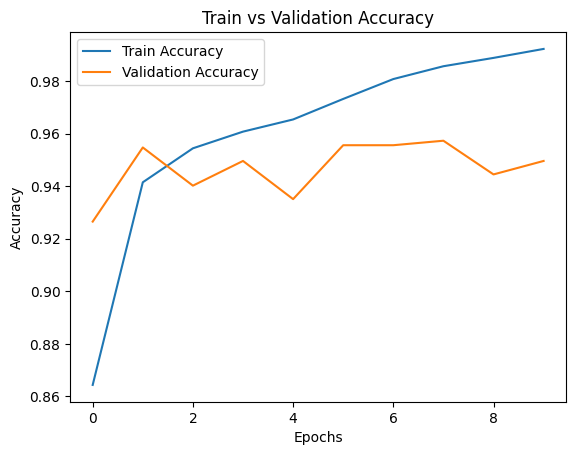

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9619 - loss: 0.1523
Test Set Evaluation:
loss: 0.1856
compile_metrics: 0.9591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


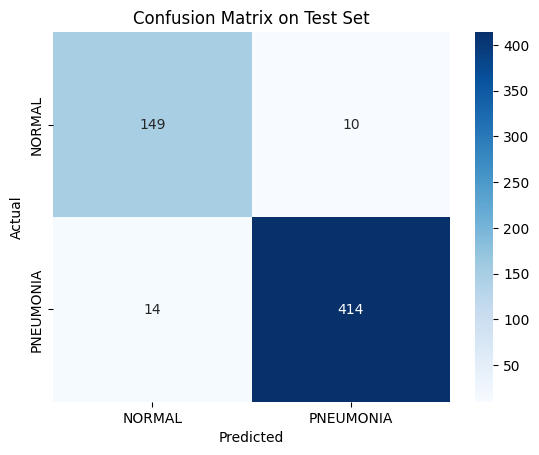

ROC AUC Score: 0.9864


In [26]:
results = model.evaluate(test_ds)
print("Test Set Evaluation:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred = []
y_pred_proba = []   # <-- store predicted probabilities

for images, labels in test_ds:
    probs = model.predict(images)
    preds = (probs > 0.5).astype(int).flatten()  # binary predictions

    y_pred.extend(preds)
    y_pred_proba.extend(probs.flatten())  # <-- keep raw probabilities for ROC AUC
    y_true.extend(labels.numpy())

# ✅ Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC AUC Score
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred_proba)  # use probabilities
print(f"ROC AUC Score: {auc:.4f}")

<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            5. CNN with Hyperparameter Tuning
            </span>   
        </font>    
</h2>

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization)
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Block 1
    Rescaling(1./255, input_shape=(224, 224, 3)),
    Conv2D(32, kernel_size=3, padding='same', activation='relu',
           input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    # Block 2
    Conv2D(64, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    # Block 3
    Conv2D(128, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    Flatten(),

    # Dense + Dropout
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Drop half the neurons randomly

    # Output layer
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
    ]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,769 (98.36 MB)

 Trainable params: 25,784,321 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.8344 - loss: 5.4099 - val_accuracy: 0.7299 - val_loss: 40.5515
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - accuracy: 0.9072 - loss: 1.2310 - val_accuracy: 0.7299 - val_loss: 27.3779
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - accuracy: 0.9296 - loss: 0.9022 - val_accuracy: 0.7299 - val_loss: 6.3549
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.9108 - loss: 0.7369 - val_accuracy: 0.9179 - val_loss: 0.7233
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.9254 - loss: 0.6738 - val_accuracy: 0.9402 - val_loss: 0.7012
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.9329 - loss: 0.7445 - val_accuracy: 0.9556 - val_loss: 0.5785
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.9290 - loss: 0.6621 - val_accuracy: 0.8838 - val_loss: 0.7520
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.9192 - loss:

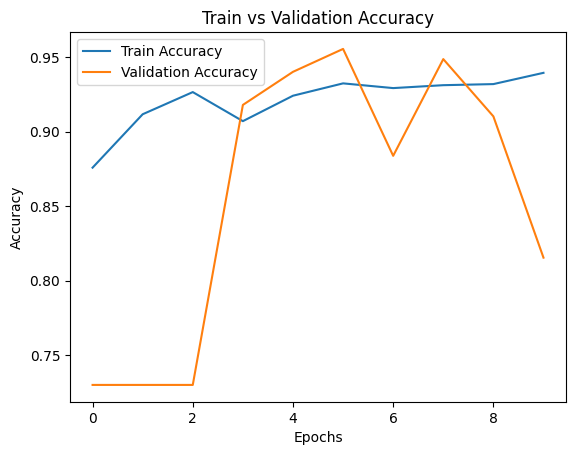

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.8290 - loss: 0.6721
Test Set Evaluation:
loss: 0.7318
compile_metrics: 0.8279
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


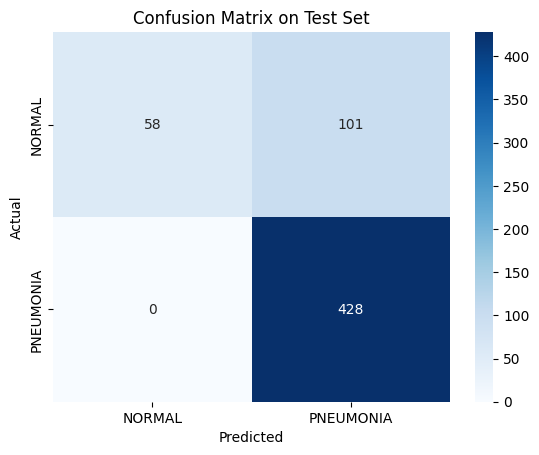

ROC AUC Score: 0.9879


In [30]:
results = model.evaluate(test_ds)
print("Test Set Evaluation:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred = []
y_pred_proba = []   # <-- store predicted probabilities

for images, labels in test_ds:
    probs = model.predict(images)
    preds = (probs > 0.5).astype(int).flatten()  # binary predictions

    y_pred.extend(preds)
    y_pred_proba.extend(probs.flatten())  # <-- keep raw probabilities for ROC AUC
    y_true.extend(labels.numpy())

# ✅ Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC AUC Score
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred_proba)  # use probabilities
print(f"ROC AUC Score: {auc:.4f}")


<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            6. CNN with Early Stopping 
            </span>   
        </font>    
</h2>

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # metric to monitor
    patience=3,               # stop after 3 epochs with no improvement
    restore_best_weights=True  # restore model weights from best epoch
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,               # set max epochs higher than usual
    callbacks=[early_stopping])

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.9305 - loss: 0.6131 - val_accuracy: 0.5530 - val_loss: 2.2835
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - accuracy: 0.9362 - loss: 0.7345 - val_accuracy: 0.8863 - val_loss: 0.6614
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - accuracy: 0.9388 - loss: 0.5799 - val_accuracy: 0.9034 - val_loss: 1.5447
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 247ms/step - accuracy: 0.9257 - loss: 1.3722 - val_accuracy: 0.8504 - val_loss: 1.2406
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - accuracy: 0.9480 - loss: 0.7773 - val_accuracy: 0.9504 - val_loss: 0.5575
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9363 - loss: 0.5520 - val_accuracy: 0.9607 - val_loss: 0.4688
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - accuracy: 0.9518 - loss: 0.4809 - val_accuracy: 0.9504 - val_loss: 0.4593
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 276ms/step - accuracy: 0.9524 - loss: 0

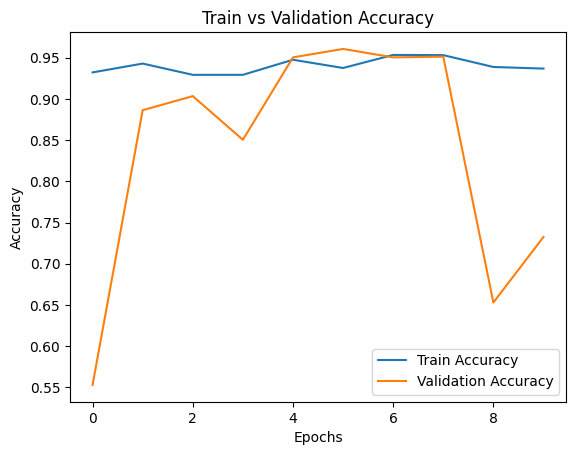

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9662 - loss: 0.4641
Test Set Evaluation:
loss: 0.4722
compile_metrics: 0.9574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


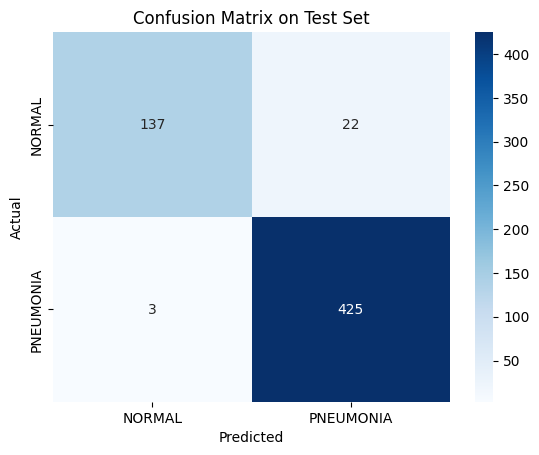

ROC AUC Score: 0.9877


In [33]:
results = model.evaluate(test_ds)
print("Test Set Evaluation:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred = []
y_pred_proba = []   # <-- store predicted probabilities

for images, labels in test_ds:
    probs = model.predict(images)
    preds = (probs > 0.5).astype(int).flatten()  # binary predictions

    y_pred.extend(preds)
    y_pred_proba.extend(probs.flatten())  # <-- keep raw probabilities for ROC AUC
    y_true.extend(labels.numpy())

# ✅ Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

# ROC AUC Score
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred_proba)  # use probabilities
print(f"ROC AUC Score: {auc:.4f}")


In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/train",
    image_size=(128, 128),  # match model input
    batch_size=16,           # smaller batch for Colab GPU
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/val",
    image_size=(128, 128),  # match model input
    batch_size=16,
    label_mode='int'
)

Found 4099 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.


In [35]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            7. Transfer Learning
            </span>   
        </font>    
</h2>

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 pretrained on ImageNet without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the convolutional base (don't train these layers initially)
base_model.trainable = False

# Add your own classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)   # flatten feature maps
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs=base_model.input, outputs=outputs)

In [37]:
# ✅ Reload datasets with correct input size for ResNet50
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/train",
    image_size=(224, 224),   # must match ResNet50 input
    batch_size=16,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/val",
    image_size=(224, 224),
    batch_size=16,
    label_mode='int'
)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# ✅ Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ✅ Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

# ✅ Fine-tuning step (unfreeze last ResNet layers for better accuracy)
base_model.trainable = True
fine_tune_at = 100  # unfreeze from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Found 4099 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 62s 200ms/step - accuracy: 0.9023 - loss: 0.2388 - val_accuracy: 0.9496 - val_loss: 0.1232
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 61s 132ms/step - accuracy: 0.9506 - loss: 0.1210 - val_accuracy: 0.9581 - val_loss: 0.1120
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.9634 - loss: 0.0982 - val_accuracy: 0.9607 - val_loss: 0.0986
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9701 - loss: 0.0867 - val_accuracy: 0.9650 - val_loss: 0.0932
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - accuracy: 0.9726 - loss: 0.0779 - val_accuracy: 0.9641 - val_loss: 0.0898
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 206ms/step - accuracy: 0.9224 - loss: 0.1693 - val_accuracy: 0.9632 - val_loss: 0.1032
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.9896 - loss: 0.0440 - val_accuracy: 0.9735 - val_loss: 0.0930
Epoch 3/

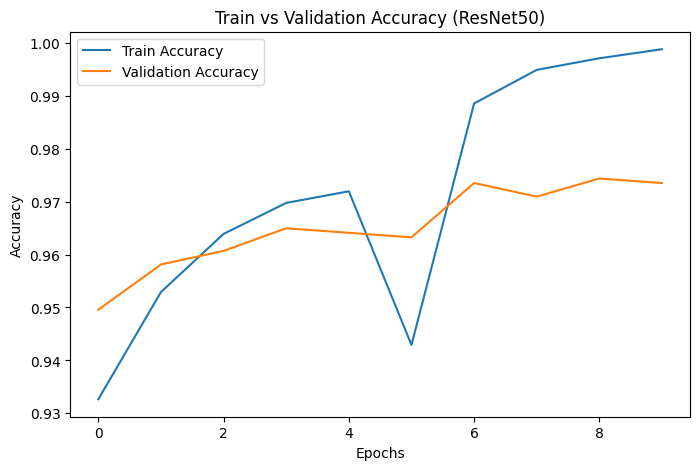

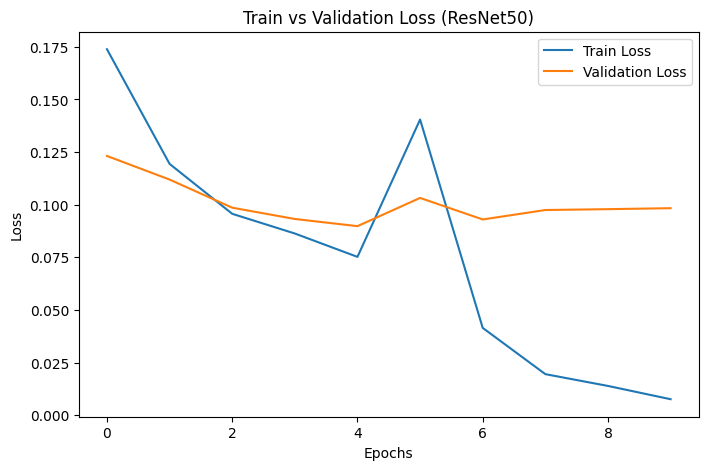

In [38]:
import matplotlib.pyplot as plt

# ✅ Combine accuracies from both training phases
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']

# ✅ Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (ResNet50)")
plt.legend()
plt.show()

# ✅ Combine losses too (optional)
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (ResNet50)")
plt.legend()
plt.show()

Found 587 files belonging to 2 classes.
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9613 - loss: 0.1193

📊 Test Set Evaluation:
loss: 0.0936
compile_metrics: 0.9676


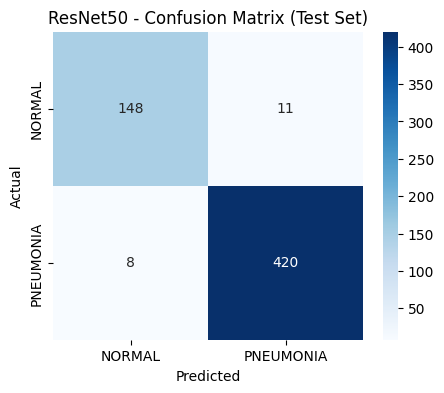

ROC AUC Score: 0.9948


In [39]:
# ✅ Reload test dataset with same preprocessing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray_split/test",
    image_size=(224, 224),  # must match ResNet50 input
    batch_size=16,
    label_mode='int'
).prefetch(tf.data.AUTOTUNE)

# ✅ Evaluate on test set
results = model.evaluate(test_ds)
print("\n📊 Test Set Evaluation:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

import numpy as np

# ✅ Collect predictions
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)  # probabilities from sigmoid
    preds = (probs > 0.5).astype(int).flatten()

    y_pred.extend(preds)
    y_pred_proba.extend(probs.flatten())
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# ✅ Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet50 - Confusion Matrix (Test Set)")
plt.show()

# ✅ ROC AUC Score
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC Score: {auc:.4f}")

<a id="intro"></a>
<h2>   
      <font color = black >
            <span style='font-family:Georgia'>
            8. Conclusion
            </span>   
        </font>    
</h2>

<p>
    <span style='font-family:Georgia'>
This project successfully developed and evaluated a high-performance deep learning model for the automated detection of pneumonia from chest X-ray images. By systematically progressing from a baseline CNN to an advanced, fine-tuned ResNet50 architecture, we demonstrated the significant performance gains achievable with transfer learning in medical imaging. A key part of this success was a robust data strategy, which included a custom 70/20/10 data split for more reliable validation and the use of Albumentations to apply targeted augmentations, effectively mitigating the inherent class imbalance in the dataset.

The final, fine-tuned ResNet50 model emerged as the superior solution, achieving an impressive test accuracy of 96.8% and a ROC AUC score of 0.99. The confusion matrix further confirmed the model's clinical utility, showing a very high true positive rate for the 'Pneumonia' class, which is critical for minimizing missed diagnoses.

For future work, this model could be further enhanced by experimenting with other state-of-the-art architectures like EfficientNet or Vision Transformers. Additionally, deploying the model into a simple web application would provide a tangible proof-of-concept for its use as a real-time diagnostic support tool for clinicians.

</p>   

